# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

### Import packages

In [2]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

### Load the dataset

In [3]:
drug_safety = pd.read_csv("drug_safety.csv")
drug_safety

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0
...,...,...,...,...,...,...,...,...
16098,78,male,Placebo,16,NaN,NaN,Yes,1
16099,78,male,Placebo,2,7.5,4.9,No,0
16100,78,male,Placebo,20,NaN,NaN,Yes,1
16101,78,male,Placebo,4,6.4,4.8,No,0


### Count the adverse_effect column values for each trx group

In [4]:
adv_eff_by_trx = drug_safety.groupby("trx").adverse_effects.value_counts()
adv_eff_by_trx

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: count, dtype: int64

### Compute total rows in each group

In [5]:
adv_eff_by_trx_totals = adv_eff_by_trx.groupby("trx").sum()
adv_eff_by_trx_totals

trx
Drug       10727
Placebo     5376
Name: count, dtype: int64

### Create an array of the "Yes" counts for each group

In [6]:
yeses = [adv_eff_by_trx["Drug"]["Yes"], adv_eff_by_trx["Placebo"]["Yes"]]
yeses

[1024, 512]

### Create an array of the total number of rows in each group

In [7]:
n = [adv_eff_by_trx_totals["Drug"], adv_eff_by_trx_totals["Placebo"]]
n

[10727, 5376]

### Perform a two-sided z-test on the two proportions

In [8]:
two_sample_results = proportions_ztest(yeses, n)
two_sample_results

(0.0452182684494942, 0.9639333330262475)

### Store the p-value

In [9]:
two_sample_p_value = two_sample_results[1]
two_sample_p_value

0.9639333330262475

### Determine if num_effects and trx are independent

In [11]:
num_effects_groups = pingouin.chi2_independence(
    data = drug_safety, x = "num_effects", y = "trx")
num_effects_groups

/Users/egifermana/anaconda3/lib/python3.11/site-packages/pingouin/contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
/Users/egifermana/anaconda3/lib/python3.11/site-packages/pingouin/contingency.py:150: UserWarning: Low count on expected frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))


(trx                 Drug      Placebo
 num_effects                          
 0            9703.794883  4863.205117
 1             960.587096   481.412904
 2              58.621126    29.378874
 3               3.996895     2.003105,
 trx          Drug  Placebo
 num_effects               
 0            9703     4864
 1             956      486
 2              63       25
 3               5        1,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
 1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
 2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
 3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
 4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
 5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189)

### Extract the p-value

In [12]:
num_effects_p_value = num_effects_groups[2]["pval"][0]
num_effects_p_value

0.6150123339426765

### Create a histogram with Seaborn

/Users/egifermana/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

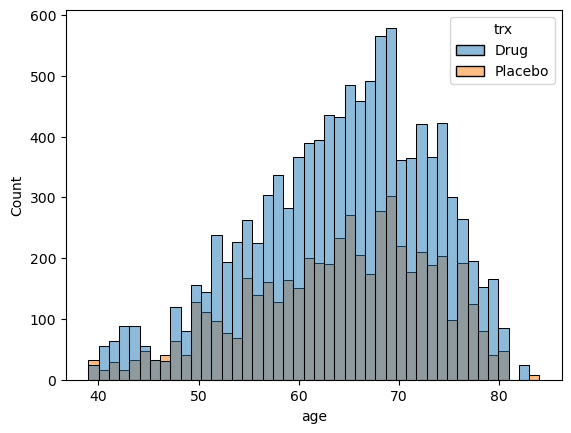

In [13]:
sns.histplot(data = drug_safety, 
             x = "age", 
             hue = "trx")

## Confirm the histogram's output by conducting a normality test
### To choose between unpaired t-test and Wilcoxon-Mann-Whitney test

In [19]:
normality = pingouin.normality(
    data = drug_safety,
    dv = 'age',
    group = 'trx',
    method = 'shapiro', # the default
    alpha = 0.05) # 0.05 is also the default
normality

/Users/egifermana/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/egifermana/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
trx,,,
Drug,0.976785,2.190318e-38,False
Placebo,0.975595,2.224615e-29,False


### Select the age of the Drug group

In [15]:
age_trx = drug_safety.loc[drug_safety["trx"] == "Drug", "age"]
age_trx

0        62
1        62
2        62
3        62
4        62
         ..
16074    60
16075    60
16092    68
16093    68
16094    68
Name: age, Length: 10727, dtype: int64

### Select the age of the Placebo group

In [16]:
age_placebo = drug_safety.loc[drug_safety["trx"] == "Placebo", "age"]
age_placebo

32       73
33       73
34       73
35       73
36       73
         ..
16098    78
16099    78
16100    78
16101    78
16102    78
Name: age, Length: 5376, dtype: int64

### Since the data distribution is not normal, conduct a two-sided Mann-Whitney U test

In [17]:
age_group_effects = pingouin.mwu(age_trx, age_placebo)
age_group_effects

,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.256963,-0.01093,0.505465


### Extract the p-value

In [18]:
age_group_effects_p_value = age_group_effects["p-val"]
age_group_effects_p_value

MWU    0.256963
Name: p-val, dtype: float64